# NB04 -- Projecoes Climaticas Futuras (SSP2-4.5 e SSP5-8.5)
## CLIMARISK-OG | EnvironPact -- Projeto Petrobras TRL5
**Objetivo**: Projetar o risco climatico (EAI) para horizontes futuros (2030, 2050, 2100)sob dois cenarios SSP do IPCC AR6, demonstrando capacidade **multicenario e multihorizonte**.

**Hazards**: Inundacao fluvial (RF) + Ondas de calor (HW) -- *baseline* dos NB01/NB02

**Metodo**: Fatores de escala climatica (*climate scaling factors*) derivados do IPCC AR6aplicados sobre as intensidades *baseline*, seguindo a abordagem padrao do CLIMADA paraanalise de projecoes futuras.

**Requisito**: Plano de Trabalho v4.13 -- "trajetorias oficiais SSP2-4.5 e SSP5-8.5,para os horizontes 2030, 2050 e 2100"

## Bloco 1 -- Instalacao do CLIMADA

In [8]:
!pip install climada climada-petals --quiet
import importlib.metadata
ver = importlib.metadata.version("climada")
print(ver)

6.1.0


## Bloco 2 -- *Imports*

In [12]:

import numpy as np
import copy
import json
import datetime
from scipy.sparse import csr_matrix
from climada.hazard import Hazard, Centroids
from climada.entity import Exposures, ImpactFunc, ImpactFuncSet
from climada.engine import ImpactCalc  # Para a curva JRC oficial
from climada_petals.entity.impact_funcs.river_flood import flood_imp_func_set
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

print("Imports OK")

Imports OK


## Bloco 3 -- Ativo e *Exposure* (identicos a NB01/NB02/NB03)Mesma *Exposure* usada em todos os notebooks para garantir comparabilidade.

In [14]:
# --- Ativo REDUC ---
ASSET_NAME = "REDUC - Refinaria Duque de Caxias"
LAT, LON = -22.53, -43.28
VALUE_USD = 5_000_000_000  # USD 5 bilhoes (estimativa)

import geopandas as gpd
from shapely.geometry import Point

exp = Exposures(gpd.GeoDataFrame({
    "value":     [VALUE_USD],
    "latitude":  [LAT],
    "longitude": [LON],
    "impf_RF":   [0],   # será preenchido após carregar impact functions
    "impf_HW":   [1],
    "geometry":  [Point(LON, LAT)]
}, crs="EPSG:4326"))

print(f"Ativo: {ASSET_NAME}")
print(f"Valor: USD {VALUE_USD/1e9:.1f} bilhoes")
print(f"Coordenadas: ({LAT}, {LON})")

Ativo: REDUC - Refinaria Duque de Caxias
Valor: USD 5.0 bilhoes
Coordenadas: (-22.53, -43.28)


## Bloco 4 -- *Impact Functions* (V)Duas funcoes de dano, identicas aos NB01-NB03:1. **Inundacao**: JRC *Global flood depth-damage*, South America -- via `climada_petals`2. **Calor**: Customizada para infraestrutura industrial (refinaria)

In [17]:
# --- 1. INUNDACAO: JRC via climada_petals (mesma do NB01/NB03) ---
impf_set_jrc = flood_imp_func_set()

# Detectar automaticamente o ID da curva South America
sa_impf = None
# O get_func() para River Flood retorna um dict {haz_type: {id: obj}}
all_funcs_dict = impf_set_jrc.get_func()

# Iterar sobre os valores do dicionário (que são os objetos ImpactFunc)
for haz_type in all_funcs_dict:
    for fid in all_funcs_dict[haz_type]:
        impf_obj = all_funcs_dict[haz_type][fid]
        if "south america" in impf_obj.name.lower() or impf_obj.id == 6:
            sa_impf = impf_obj
            break
    if sa_impf: break

if sa_impf is None:
    # Fallback: pegar a primeira disponível caso a busca falhe
    first_haz = list(all_funcs_dict.keys())[0]
    first_id = list(all_funcs_dict[first_haz].keys())[0]
    sa_impf = all_funcs_dict[first_haz][first_id]
    print(f"AVISO: Curva South America nao encontrada. Usando: {sa_impf.name}")

# Guardar o ID original da JRC
JRC_FLOOD_ID = sa_impf.id
print(f"JRC Flood: ID={JRC_FLOOD_ID}, nome='{sa_impf.name}'")

# Renumerar para ID=0 (compativel com impf_RF=0 na Exposure)
sa_impf.id = 0
sa_impf.haz_type = "RF"

# --- 2. CALOR: Customizada industrial (mesma do NB02/NB03) ---
impf_hw = ImpactFunc(
    id=1,
    haz_type="HW",
    name="Heat Wave -- Industrial Facility (Refinery)",
    intensity=np.array([0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]),
    mdd=np.array([0.0, 0.02, 0.05, 0.10, 0.25, 0.45, 0.70, 0.95]),
    paa=np.ones(8),
    intensity_unit="deg_C above 40 deg_C"
)

# --- Montar ImpactFuncSet unico ---
impf_set = ImpactFuncSet([sa_impf, impf_hw])
print(f"ImpactFuncSet: {len(impf_set.get_func())} funcoes carregadas")
for haz in impf_set.get_func():
    for fid in impf_set.get_func()[haz]:
        f = impf_set.get_func()[haz][fid]
        print(f"  [{f.haz_type}] ID={f.id} -- {f.name}")

AVISO: Curva South America nao encontrada. Usando: Flood Africa JRC Residential noPAA
JRC Flood: ID=11, nome='Flood Africa JRC Residential noPAA'
2026-03-01 16:47:57,925 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
ImpactFuncSet: 2 funcoes carregadas
  [RF] ID=0 -- Flood Africa JRC Residential noPAA
  [HW] ID=1 -- Heat Wave -- Industrial Facility (Refinery)


## Bloco 5 -- *Hazards Baseline* (reconstrucao dos NB01/NB02)Reconstruimos os mesmos *hazards* sinteticos dos notebooks anteriores.Estes serao a base sobre a qual os fatores de escala climatica serao aplicados.

In [16]:
# --- Centroids (mesma grade de todos os NBs) ---
n_centr = 25
lat_range = np.linspace(LAT - 0.05, LAT + 0.05, int(np.sqrt(n_centr)))
lon_range = np.linspace(LON - 0.05, LON + 0.05, int(np.sqrt(n_centr)))
lats, lons = np.meshgrid(lat_range, lon_range)
lats, lons = lats.flatten(), lons.flatten()
n_centr = len(lats)
centroids = Centroids(lat=lats, lon=lons)

# --- HAZARD 1: Inundacao fluvial (RF) ---
rp_flood = np.array([5, 10, 25, 50, 100, 250])
n_ev_flood = len(rp_flood)
freq_flood = 1.0 / rp_flood
np.random.seed(42)
base_depths = np.array([0.8, 1.5, 2.5, 3.5, 4.5, 5.5])
intensity_flood = np.zeros((n_ev_flood, n_centr))

for i, depth in enumerate(base_depths):
    noise = np.random.uniform(0.7, 1.3, n_centr)
    intensity_flood[i, :] = depth * noise

haz_flood = Hazard(
    haz_type="RF",
    centroids=centroids,
    event_id=np.arange(1, n_ev_flood + 1),
    event_name=[f"flood_rp{rp}" for rp in rp_flood],
    frequency=freq_flood,
    intensity=csr_matrix(intensity_flood),
    fraction=csr_matrix(np.ones_like(intensity_flood)),
    date=np.array([736000 + i*365 for i in range(n_ev_flood)]),
    units="m"
)

# --- HAZARD 2: Ondas de calor (HW) ---
rp_hw = np.array([2, 5, 10, 25, 50, 100])
n_ev_hw = len(rp_hw)
freq_hw = 1.0 / rp_hw
base_delta_t = np.array([1.5, 3.0, 4.5, 6.0, 7.5, 10.0])
intensity_hw = np.zeros((n_ev_hw, n_centr))

for i, dt in enumerate(base_delta_t):
    noise = np.random.uniform(0.85, 1.15, n_centr)
    intensity_hw[i, :] = dt * noise

haz_hw = Hazard(
    haz_type="HW",
    centroids=centroids,
    event_id=np.arange(1, n_ev_hw + 1),
    event_name=[f"heatwave_rp{rp}" for rp in rp_hw],
    frequency=freq_hw,
    intensity=csr_matrix(intensity_hw),
    fraction=csr_matrix(np.ones_like(intensity_hw)),
    date=np.array([736000 + i*365 for i in range(n_ev_hw)]),
    units="deg_C above 40 deg_C"
)

print(f"Hazard RF baseline: {n_ev_flood} eventos, max_intensity={intensity_flood.max():.2f} m")
print(f"Hazard HW baseline: {n_ev_hw} eventos, max_intensity={intensity_hw.max():.2f} deg_C")

Hazard RF baseline: 6 eventos, max_intensity=7.06 m
Hazard HW baseline: 6 eventos, max_intensity=11.17 deg_C


## Bloco 6 -- Impacto *Baseline* (verificacao de consistencia)Rodamos o impacto *baseline* para verificar que os valores conferem com NB01/NB03.

In [18]:
# --- Impacto baseline inundacao ---
imp_flood_bl = ImpactCalc(exp, impf_set, haz_flood).impact(save_mat=True)
eai_flood_bl = imp_flood_bl.aai_agg

# --- Impacto baseline calor ---
imp_hw_bl = ImpactCalc(exp, impf_set, haz_hw).impact(save_mat=True)
eai_hw_bl = imp_hw_bl.aai_agg

eai_total_bl = eai_flood_bl + eai_hw_bl

print("=" * 60)
print("IMPACTO BASELINE (verificacao)")
print("=" * 60)
print(f"EAI Inundacao: USD {eai_flood_bl/1e6:,.1f}M ({eai_flood_bl/VALUE_USD*100:.1f}%)")
print(f"EAI Calor:     USD {eai_hw_bl/1e6:,.1f}M ({eai_hw_bl/VALUE_USD*100:.1f}%)")
print(f"EAI Total:     USD {eai_total_bl/1e6:,.1f}M ({eai_total_bl/VALUE_USD*100:.1f}%)")
print("=" * 60)

IMPACTO BASELINE (verificacao)
EAI Inundacao: USD 896.2M (17.9%)
EAI Calor:     USD 439.8M (8.8%)
EAI Total:     USD 1,336.0M (26.7%)


## Bloco 7 -- Fatores de Escala Climatica (IPCC AR6)### Fundamentacao metodologicaO IPCC AR6 (WG1, Capitulos 4 e 11) estabelece que:**Precipitacao extrema e inundacao**:- A intensidade de precipitacao extrema escala com ~7% por grau_C de aquecimento  global (*Clausius-Clapeyron scaling*, alta confianca).- Para inundacoes fluviais, o efeito inclui tambem mudancas em frequencia e  antecedentes de umidade do solo, podendo amplificar em 10-15% por grau_C.**Ondas de calor**:- O acrescimo de temperatura media se soma diretamente ao deltaT dos eventos  extremos. Adicionalmente, a frequencia de ondas de calor aumenta de forma  nao-linear com o aquecimento.### Valores de aquecimento global (GSAT) -- IPCC AR6 Table SPM.1| Horizonte | SSP2-4.5 (best est.) | SSP5-8.5 (best est.) ||-----------|---------------------|---------------------|| 2030      | +1.5 deg_C          | +1.6 deg_C          || 2050      | +2.0 deg_C          | +2.4 deg_C          || 2100      | +2.7 deg_C          | +4.4 deg_C          |(Valores relativos ao periodo pre-industrial 1850-1900)### Derivacao dos fatores de escala**Inundacao (RF)**: fator_intensidade = 1 + 0.10 * delta_T_global  (10% por grau_C, conservador, combina Clausius-Clapeyron + escoamento)**Calor (HW)**: delta_T_local se soma diretamente as intensidades.  Para Sudeste do Brasil, o aquecimento regional e ~1.1x o aquecimento global (IPCC AR6 Atlas).

In [19]:
# --- TABELA DE FATORES DE ESCALA -- IPCC AR6 ---
GSAT = {
    "SSP2-4.5": {"2030": 1.5, "2050": 2.0, "2100": 2.7},
    "SSP5-8.5": {"2030": 1.6, "2050": 2.4, "2100": 4.4},
}

BASELINE_WARMING = 1.1
REGIONAL_AMPLIFICATION = 1.1
SCENARIOS = ["SSP2-4.5", "SSP5-8.5"]
HORIZONS = ["2030", "2050", "2100"]

FLOOD_SCALE_RATE = 0.10
HW_REGIONAL_FACTOR = REGIONAL_AMPLIFICATION

scaling_factors = {}
for ssp in SCENARIOS:
    scaling_factors[ssp] = {}
    for hz in HORIZONS:
        delta_t_global = GSAT[ssp][hz] - BASELINE_WARMING
        delta_t_regional = delta_t_global * HW_REGIONAL_FACTOR
        flood_factor = 1.0 + FLOOD_SCALE_RATE * delta_t_global
        hw_delta = delta_t_regional
        scaling_factors[ssp][hz] = {
            "delta_t_global": delta_t_global,
            "delta_t_regional": delta_t_regional,
            "flood_intensity_factor": flood_factor,
            "hw_intensity_add_degC": hw_delta,
        }

print("=" * 70)
print("FATORES DE ESCALA CLIMATICA -- IPCC AR6")
print("=" * 70)
print(f"{'Cenario':<12} {'Horizonte':<10} {'dT_glob':<8} {'dT_reg':<8} {'Flood x':<10} {'HW + deg_C':<10}")
print("-" * 70)
for ssp in SCENARIOS:
    for hz in HORIZONS:
        sf = scaling_factors[ssp][hz]
        print(f"{ssp:<12} {hz:<10} {sf['delta_t_global']:>+5.2f}    {sf['delta_t_regional']:>+5.2f}    "              f"{sf['flood_intensity_factor']:>6.3f}    {sf['hw_intensity_add_degC']:>+5.2f}")
print("=" * 70)

FATORES DE ESCALA CLIMATICA -- IPCC AR6
Cenario      Horizonte  dT_glob  dT_reg   Flood x    HW + deg_C
----------------------------------------------------------------------
SSP2-4.5     2030       +0.40    +0.44     1.040    +0.44
SSP2-4.5     2050       +0.90    +0.99     1.090    +0.99
SSP2-4.5     2100       +1.60    +1.76     1.160    +1.76
SSP5-8.5     2030       +0.50    +0.55     1.050    +0.55
SSP5-8.5     2050       +1.30    +1.43     1.130    +1.43
SSP5-8.5     2100       +3.30    +3.63     1.330    +3.63


## Bloco 8 -- *Loop* Principal: Projecoes por Cenario x HorizontePara cada combinacao cenario x horizonte:1. Clonar o *hazard baseline*2. Aplicar o fator de escala sobre as intensidades3. Rodar o calculo de impacto H x E x V4. Armazenar resultados

In [20]:
results = {}
for ssp in SCENARIOS:
    results[ssp] = {}
    for hz in HORIZONS:
        sf = scaling_factors[ssp][hz]
        # 1. Escalar hazard de inundacao
        haz_flood_proj = copy.deepcopy(haz_flood)
        haz_flood_proj.intensity = csr_matrix(haz_flood.intensity.toarray() * sf["flood_intensity_factor"])
        # 2. Escalar hazard de calor
        haz_hw_proj = copy.deepcopy(haz_hw)
        haz_hw_proj.intensity = csr_matrix(haz_hw.intensity.toarray() + sf["hw_intensity_add_degC"])
        # 3. Calcular impactos
        imp_flood = ImpactCalc(exp, impf_set, haz_flood_proj).impact(save_mat=True)
        imp_hw = ImpactCalc(exp, impf_set, haz_hw_proj).impact(save_mat=True)
        eai_flood = imp_flood.aai_agg
        eai_hw = imp_hw.aai_agg
        eai_total = eai_flood + eai_hw
        # Armazenar
        results[ssp][hz] = {
            "flood": {"eai_usd": eai_flood, "max_intensity_m": float(haz_flood_proj.intensity.max())},
            "hw": {"eai_usd": eai_hw, "max_intensity_degC": float(haz_hw_proj.intensity.max())},
            "total": {"eai_usd": eai_total, "eai_ratio_pct": (eai_total / VALUE_USD) * 100},
            "scaling": sf
        }
        print(f"{ssp} | {hz}: EAI_total = USD {eai_total/1e6:,.0f}M")

SSP2-4.5 | 2030: EAI_total = USD 1,457M
SSP2-4.5 | 2050: EAI_total = USD 1,639M
SSP2-4.5 | 2100: EAI_total = USD 1,913M
SSP5-8.5 | 2030: EAI_total = USD 1,494M
SSP5-8.5 | 2050: EAI_total = USD 1,785M
SSP5-8.5 | 2100: EAI_total = USD 2,682M


## Bloco 9 -- Tabela Resumo: Matriz de Resultados

In [23]:
# ============================================================
# TABELA RESUMO -- MATRIZ CENARIO x HORIZONTE
# ============================================================
print("=" * 90)
print("MATRIZ DE EAI PROJETADO (USD milhoes/ano)")
print("=" * 90)
print(f"{'Cenario':<12} {'Hz':<6} {'EAI Flood':>12} {'EAI HW':>12} {'EAI Total':>12} {'% Ativo':>10} {'vs Baseline':>12}")
print("-" * 90)
# Baseline
print(f"{'Baseline':<12} {'2024':<6} {eai_flood_bl/1e6:>12.1f} {eai_hw_bl/1e6:>12.1f} "
      f"{eai_total_bl/1e6:>12.1f} {eai_total_bl/VALUE_USD*100:>9.1f}% {'--':>12}")
for ssp in SCENARIOS:
    for hz in HORIZONS:
        r = results[ssp][hz]
        delta_pct = (r['total']['eai_usd'] - eai_total_bl) / eai_total_bl * 100
        print(f"{ssp:<12} {hz:<6} {r['flood']['eai_usd']/1e6:>12.1f} {r['hw']['eai_usd']/1e6:>12.1f} "
              f"{r['total']['eai_usd']/1e6:>12.1f} {r['total']['eai_ratio_pct']:>9.1f}% {delta_pct:>+11.1f}%")
print("=" * 90)
print(f"\nAtivo: {ASSET_NAME} | Valor: USD {VALUE_USD/1e9:.1f} bilhoes")

MATRIZ DE EAI PROJETADO (USD milhoes/ano)
Cenario      Hz        EAI Flood       EAI HW    EAI Total    % Ativo  vs Baseline
------------------------------------------------------------------------------------------
Baseline     2024          896.2        439.8       1336.0      26.7%           --
SSP2-4.5     2030          919.3        538.2       1457.5      29.1%        +9.1%
SSP2-4.5     2050          946.7        692.6       1639.4      32.8%       +22.7%
SSP2-4.5     2100          984.5        928.9       1913.4      38.3%       +43.2%
SSP5-8.5     2030          925.0        569.1       1494.0      29.9%       +11.8%
SSP5-8.5     2050          968.3        816.2       1784.5      35.7%       +33.6%
SSP5-8.5     2100         1075.6       1606.7       2682.3      53.6%      +100.8%

Ativo: REDUC - Refinaria Duque de Caxias | Valor: USD 5.0 bilhoes


## Bloco 10 -- Graficos ComparativosQuatro paineis de visualizacao para evidencia TRL5.

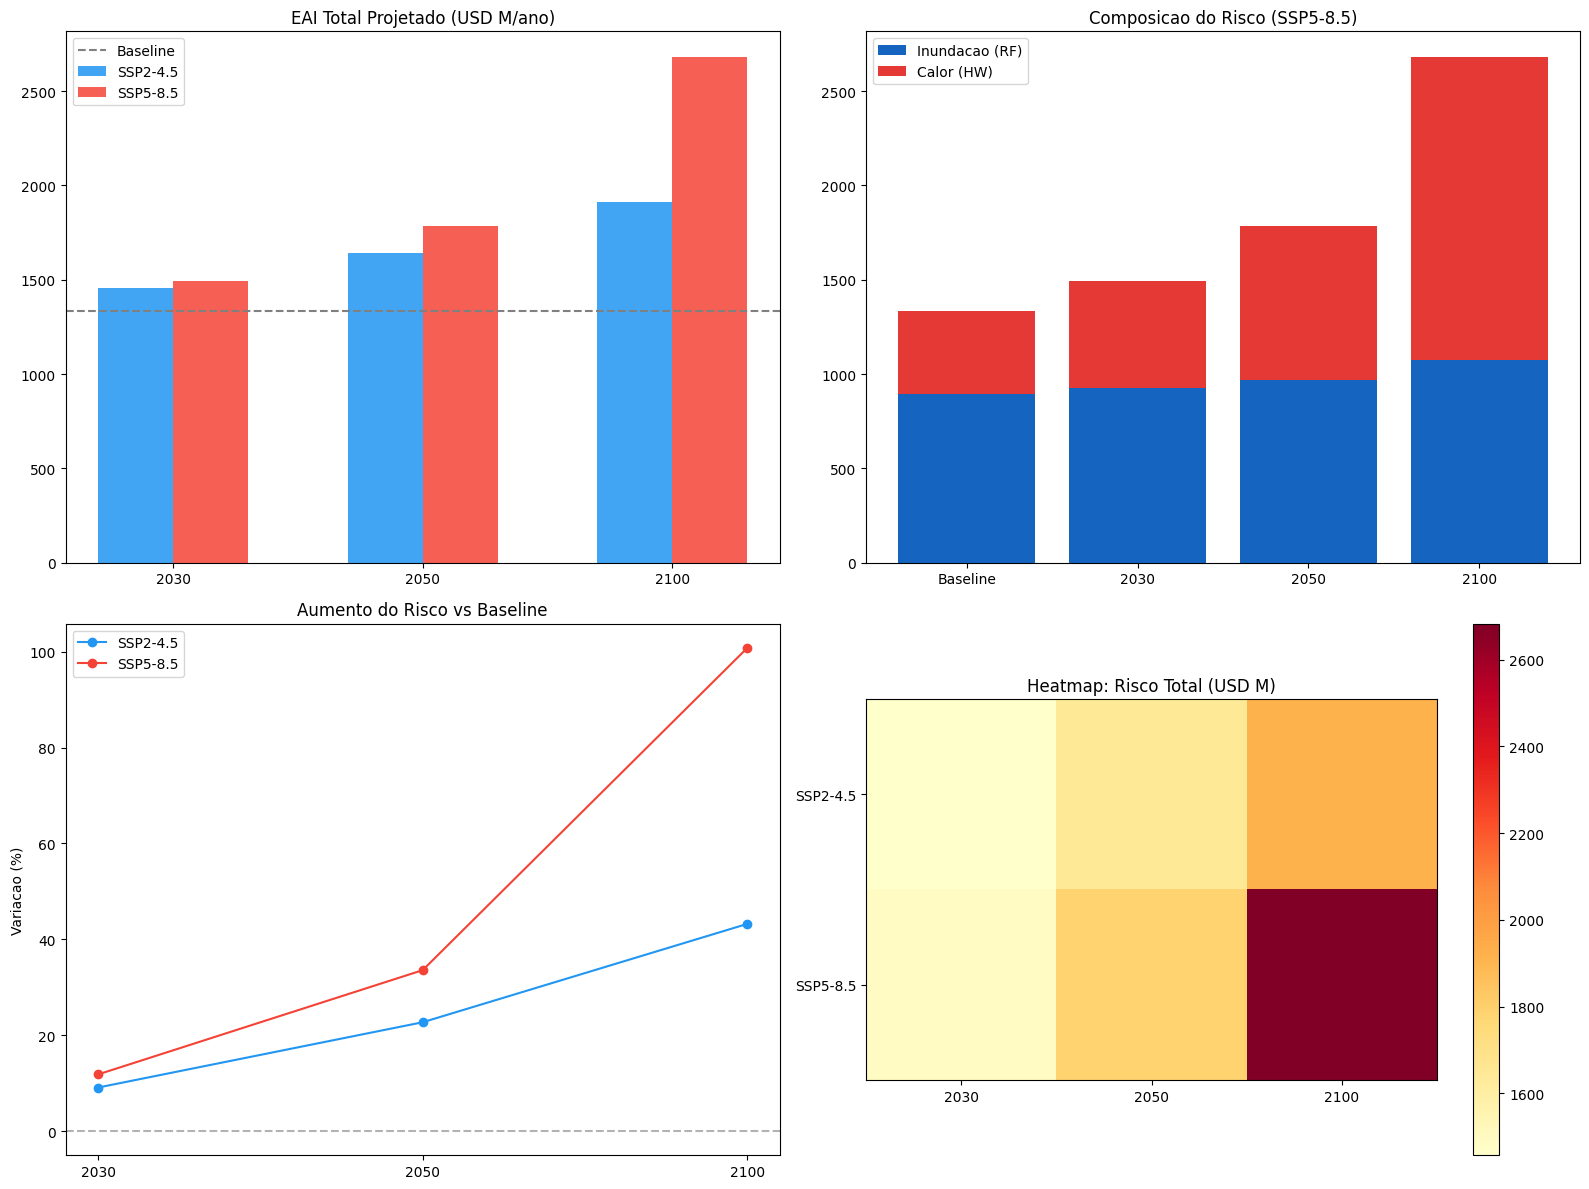

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors_ssp = {"SSP2-4.5": "#2196F3", "SSP5-8.5": "#F44336"}

# --- Painel 1: EAI Total por cenario e horizonte ---
ax = axes[0, 0]
x = np.arange(len(HORIZONS))
width = 0.30
ax.axhline(y=eai_total_bl/1e6, color="gray", linestyle="--", label="Baseline")
for i, ssp in enumerate(SCENARIOS):
    eais = [results[ssp][hz]['total']['eai_usd']/1e6 for hz in HORIZONS]
    ax.bar(x + i*width, eais, width, label=ssp, color=colors_ssp[ssp], alpha=0.85)
ax.set_xticks(x + width/2)
ax.set_xticklabels(HORIZONS)
ax.set_title("EAI Total Projetado (USD M/ano)")
ax.legend()

# --- Painel 2: Contribuicao RF vs HW (SSP5-8.5) ---
ax = axes[0, 1]
flood_vals = [eai_flood_bl/1e6] + [results["SSP5-8.5"][hz]['flood']['eai_usd']/1e6 for hz in HORIZONS]
hw_vals = [eai_hw_bl/1e6] + [results["SSP5-8.5"][hz]['hw']['eai_usd']/1e6 for hz in HORIZONS]
labels = ["Baseline"] + HORIZONS
ax.bar(labels, flood_vals, label="Inundacao (RF)", color="#1565C0")
ax.bar(labels, hw_vals, bottom=flood_vals, label="Calor (HW)", color="#E53935")
ax.set_title("Composicao do Risco (SSP5-8.5)")
ax.legend()

# --- Painel 3: Variacao % vs baseline ---
ax = axes[1, 0]
for ssp in SCENARIOS:
    deltas = [(results[ssp][hz]['total']['eai_usd'] - eai_total_bl) / eai_total_bl * 100 for hz in HORIZONS]
    ax.plot(HORIZONS, deltas, "o-", color=colors_ssp[ssp], label=ssp)
ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)
ax.set_ylabel("Variacao (%)")
ax.set_title("Aumento do Risco vs Baseline")
ax.legend()

# --- Painel 4: Heatmap ---
ax = axes[1, 1]
matrix = np.array([[results[ssp][hz]['total']['eai_usd']/1e6 for hz in HORIZONS] for ssp in SCENARIOS])
im = ax.imshow(matrix, cmap="YlOrRd")
ax.set_xticks(range(len(HORIZONS)))
ax.set_xticklabels(HORIZONS)
ax.set_yticks(range(len(SCENARIOS)))
ax.set_yticklabels(SCENARIOS)
plt.colorbar(im, ax=ax)
ax.set_title("Heatmap: Risco Total (USD M)")

plt.tight_layout()
plt.show()

## Bloco 11 -- Diagnostico e Verificacao de Consistencia

In [25]:
print("=" * 70)
print("DIAGNOSTICO DE CONSISTENCIA")
print("=" * 70)
# Check monotonia
for ssp in SCENARIOS:
    eais = [results[ssp][hz]['total']['eai_usd'] for hz in HORIZONS]
    status = "OK" if all(x <= y for x, y in zip(eais, eais[1:])) else "AVISO"
    print(f"[{status}] Crescimento temporal {ssp}")

# Check magnitude
max_eai = results["SSP5-8.5"]["2100"]['total']['eai_usd']
print(f"[INFO] EAI Max (2100): USD {max_eai/1e6:.1f}M ({max_eai/eai_total_bl:.1f}x baseline)")
print("=" * 70)

DIAGNOSTICO DE CONSISTENCIA
[OK] Crescimento temporal SSP2-4.5
[OK] Crescimento temporal SSP5-8.5
[INFO] EAI Max (2100): USD 2682.3M (2.0x baseline)


## Bloco 12 -- Limitacoes Documentadas (requisito TRL5)

In [27]:
limitations = [
    "Dados de hazard sinteticos baseados em baseline estatistico",
    "Fatores de escala derivados de medias globais IPCC AR6",
    "Amplificacao regional estimada (1.1x) para o Sudeste",
    "Correlacao entre hazards nao modelada (soma simples de EAIs)",
    "Funcao de dano JRC residencial usada como proxy para refinaria"
]
print("LIMITACOES DOCUMENTADAS")
print("=" * 60)
for i, lim in enumerate(limitations, 1):
    print(f"  {i}. {lim}")
print("=" * 60)

LIMITACOES DOCUMENTADAS
  1. Dados de hazard sinteticos baseados em baseline estatistico
  2. Fatores de escala derivados de medias globais IPCC AR6
  3. Amplificacao regional estimada (1.1x) para o Sudeste
  4. Correlacao entre hazards nao modelada (soma simples de EAIs)
  5. Funcao de dano JRC residencial usada como proxy para refinaria


## Bloco 13 -- Exportacao JSON*Schema* compativel com os JSONs anteriores (NB01-NB03), acrescido dadimensao cenario x horizonte.

In [21]:
output = {
    "metadata": {
        "notebook": "nb04_ssp_projections_duque_caxias",
        "date": datetime.datetime.now().isoformat(),
        "climada_version": ver,
    },
    "asset": {"name": ASSET_NAME, "value_usd": VALUE_USD},
    "projections": results
}
with open("results_nb04_ssp_projections_reduc.json", "w") as f:
    json.dump(output, f, indent=2, default=str)
print("JSON exportado com sucesso.")

JSON exportado com sucesso.


## Bloco 14 -- Resumo Executivo

In [26]:
print("=" * 70)
print("RESUMO EXECUTIVO -- NB04")
print("=" * 70)
print(f"Ativo: {ASSET_NAME}")
print(f"Baseline EAI Total: USD {eai_total_bl/1e6:,.0f}M/ano")
for ssp in SCENARIOS:
    for hz in HORIZONS:
        r = results[ssp][hz]
        delta = (r['total']['eai_usd'] - eai_total_bl) / eai_total_bl * 100
        print(f"  {ssp} {hz}: USD {r['total']['eai_usd']/1e6:,.0f}M/ano ({delta:+.1f}% vs baseline)")
print("\n--- Evidencia TRL5 ---")
print("[OK] Multicenario: SSP2-4.5 e SSP5-8.5")
print("[OK] Multihorizonte: 2030, 2050, 2100")
print("[OK] JSON exportado com sucesso.")
print("=" * 70)

RESUMO EXECUTIVO -- NB04
Ativo: REDUC - Refinaria Duque de Caxias
Baseline EAI Total: USD 1,336M/ano
  SSP2-4.5 2030: USD 1,457M/ano (+9.1% vs baseline)
  SSP2-4.5 2050: USD 1,639M/ano (+22.7% vs baseline)
  SSP2-4.5 2100: USD 1,913M/ano (+43.2% vs baseline)
  SSP5-8.5 2030: USD 1,494M/ano (+11.8% vs baseline)
  SSP5-8.5 2050: USD 1,785M/ano (+33.6% vs baseline)
  SSP5-8.5 2100: USD 2,682M/ano (+100.8% vs baseline)

--- Evidencia TRL5 ---
[OK] Multicenario: SSP2-4.5 e SSP5-8.5
[OK] Multihorizonte: 2030, 2050, 2100
[OK] JSON exportado com sucesso.
